In [75]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [146]:
### Synthetic data
np.random.seed(909)
num_patients = 50

x_bw = np.random.uniform(50, 120, num_patients) #body weight
x_comed = np.random.randint(0, 2, num_patients)#comed
x_raw = np.c_[x_bw, x_comed]
###Clearance (L/hr)
y = (10 + 0.1 * x_bw + 2 * x_comed * (x_bw / 100) ** 2 +
     np.random.normal(0, 0.5, num_patients))
#scaling for ml
scaler = MinMaxScaler()
x = scaler.fit_transform(x_raw)
# training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print(f"{len(x_train)} training patients, {len(x_test)} test patients.")



40 training patients, 10 test patients.


In [147]:
### Quantum kernel
n_qubits = 2 
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map_template(features):
    """A circuit template to encode classical features into a quantum state."""
    #AngleEmbedding
    qml.AngleEmbedding(features, wires=range(n_qubits))
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def kernel_circuit(a, b):
    """Quantum circuit to calculate the kernel value for two inputs."""
    feature_map_template(a)
    qml.adjoint(feature_map_template)(b)
    return qml.probs(wires=range(n_qubits))

def quantum_kernel(a, b):
    """Computes the similarity between two feature vectors a and b."""
    return kernel_circuit(a, b)[0]


In [148]:
# @qml.qnode(dev)
# def circuit(a):
#     feature_map_template(a)
#     qml.adjoint(feature_map_template)(a)
#     return qml.probs(wires=range(n_qubits))

# fig, ax = qml.draw_mpl(circuit)(x_train[0])
# plt.tight_layout()
# plt.show()

# print("Circuit representation:")
# print(qml.draw(circuit)(x_train[0]))

Model training complete.

Model Performance on Test Set:
  R-squared (R²):           0.8037
  Mean Squared Error (MSE):   0.7061
  Root Mean Squared Error (RMSE): 0.8403
  Mean Absolute Error (MAE):  0.6866

Individual Predictions:
  Patient BW: 63.4 kg, COMED: 1 -> Predicted CL: 17.20 L/hr (Actual: 17.04 L/hr)
  Patient BW: 78.1 kg, COMED: 0 -> Predicted CL: 19.59 L/hr (Actual: 20.29 L/hr)
  Patient BW: 88.8 kg, COMED: 1 -> Predicted CL: 18.96 L/hr (Actual: 18.65 L/hr)
  Patient BW: 92.4 kg, COMED: 0 -> Predicted CL: 17.98 L/hr (Actual: 16.81 L/hr)
  Patient BW: 83.5 kg, COMED: 1 -> Predicted CL: 19.95 L/hr (Actual: 21.08 L/hr)
  Patient BW: 84.9 kg, COMED: 0 -> Predicted CL: 18.74 L/hr (Actual: 18.85 L/hr)
  Patient BW: 62.6 kg, COMED: 1 -> Predicted CL: 20.27 L/hr (Actual: 21.39 L/hr)
  Patient BW: 100.2 kg, COMED: 1 -> Predicted CL: 18.93 L/hr (Actual: 18.95 L/hr)
  Patient BW: 53.9 kg, COMED: 0 -> Predicted CL: 17.25 L/hr (Actual: 15.84 L/hr)
  Patient BW: 68.5 kg, COMED: 0 -> Pre

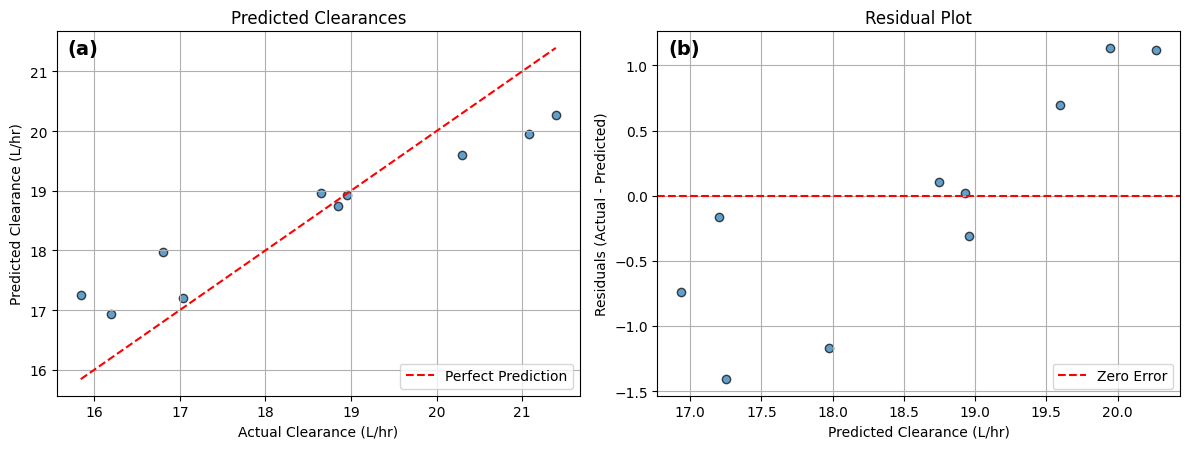

In [149]:
### regression training
kernel_matrix_train = qml.kernels.square_kernel_matrix(x_train, quantum_kernel)

svr = SVR(kernel='precomputed')
svr.fit(kernel_matrix_train, y_train)
print("Model training complete.")


### Eval

kernel_matrix_test = qml.kernels.kernel_matrix(x_test, x_train, quantum_kernel)

# Make predictions
y_pred = svr.predict(kernel_matrix_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"  R-squared (R²):           {r2:.4f}")
print(f"  Mean Squared Error (MSE):   {mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  Mean Absolute Error (MAE):  {mae:.4f}")

print("\nIndividual Predictions:")
for i in range(len(y_test)):
    original_features = scaler.inverse_transform([X_test[i]])
    print(f"  Patient BW: {original_features[0][0]:.1f} kg, COMED: {int(original_features[0][1])} -> "
          f"Predicted CL: {y_pred[i]:.2f} L/hr (Actual: {y_test[i]:.2f} L/hr)")


# Error of predictions

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')

perfect_line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(perfect_line, perfect_line, 'r--', label='Perfect Prediction')
plt.xlabel("Actual Clearance (L/hr)")
plt.ylabel("Predicted Clearance (L/hr)")
plt.title("Predicted Clearances")
plt.text(0.02, 0.98, '(a)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', 
         verticalalignment='top', horizontalalignment='left')

plt.legend()
plt.grid(True)

residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
plt.xlabel("Predicted Clearance (L/hr)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.text(0.02, 0.98, '(b)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', 
         verticalalignment='top', horizontalalignment='left')
plt.legend()
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

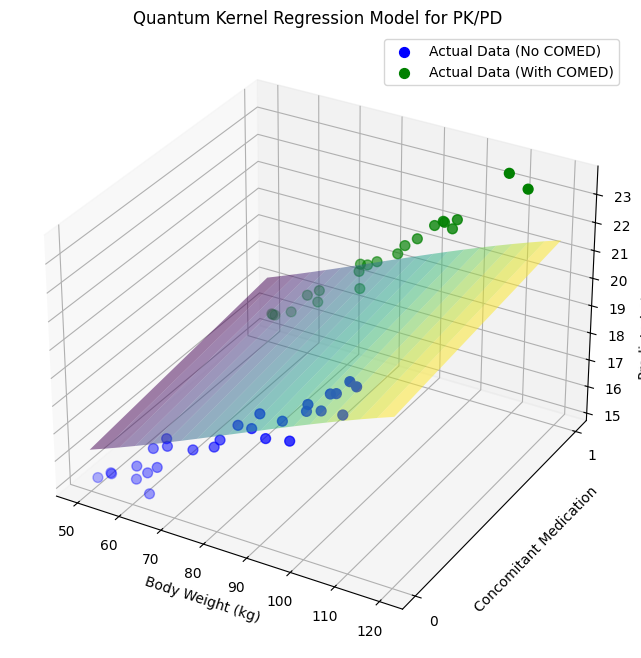

In [150]:
#Model vis...
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

comed_0_actual = x_raw[x_raw[:, 1] == 0]
y_0_actual = y[x_raw[:, 1] == 0]
ax.scatter(comed_0_actual[:, 0], comed_0_actual[:, 1], y_0_actual,
           c='blue', marker='o', s=50, label='Actual Data (No COMED)')

comed_1_actual = x_raw[x_raw[:, 1] == 1]
y_1_actual = y[x_raw[:, 1] == 1]
ax.scatter(comed_1_actual[:, 0], comed_1_actual[:, 1], y_1_actual,
           c='green', marker='o', s=50, label='Actual Data (With COMED)')

bw_range = np.linspace(50, 120, 20)
comed_range = np.array([0, 1])
grid_bw, grid_comed = np.meshgrid(bw_range, comed_range)

grid_x_raw = np.c_[grid_bw.ravel(), grid_comed.ravel()]
grid_x_scaled = scaler.transform(grid_x_raw)

grid_kernel_matrix = qml.kernels.kernel_matrix(grid_x_scaled, x_train, quantum_kernel)
grid_y_pred = svr.predict(grid_kernel_matrix)
grid_z = grid_y_pred.reshape(grid_bw.shape)

ax.plot_surface(grid_bw, grid_comed, grid_z, alpha=0.5, cmap='viridis', rstride=100, cstride=1)

ax.set_xlabel('Body Weight (kg)')
ax.set_ylabel('Concomitant Medication')
ax.set_zlabel('Predicted Clearance (L/hr)')
ax.set_yticks([0, 1])
ax.set_title('Quantum Kernel Regression Model for PK/PD')
plt.legend()
plt.show()
